In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model,load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.set_random_seed(123)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
print(os.listdir("../input/"))
InputPath = "content/artificial-lunar-rocky-landscape-dataset/images/"
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['artificial-lunar-rocky-landscape-dataset', 'keras-pretrained-models']


In [ ]:
print(os.listdir(InputPath+'render'))

['render3787.png', 'render0860.png', 'render4051.png', 'render2394.png', 'render0192.png', 'render8169.png', 'render8924.png', 'render3443.png', 'render5125.png', 'render5169.png', 'render6759.png', 'render7722.png', 'render6475.png', 'render4596.png', 'render2281.png', 'render8400.png', 'render7368.png', 'render0775.png', 'render7471.png', 'render0897.png', 'render8744.png', 'render2675.png', 'render8432.png', 'render2126.png', 'render1313.png', 'render6707.png', 'render5091.png', 'render8669.png', 'render0865.png', 'render1513.png', 'render2517.png', 'render1599.png', 'render5077.png', 'render0381.png', 'render7545.png', 'render1296.png', 'render5079.png', 'render3403.png', 'render9350.png', 'render8377.png', 'render2816.png', 'render2063.png', 'render7947.png', 'render8539.png', 'render9257.png', 'render4921.png', 'render2383.png', 'render9701.png', 'render7121.png', 'render6006.png', 'render7542.png', 'render5011.png', 'render1183.png', 'render5549.png', 'render2328.png', 'render96

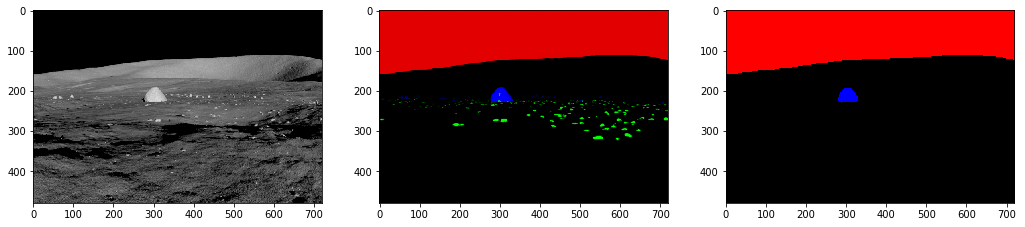

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img = cv.imread(InputPath+"render/render0001.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(5,5,1+1)
img = cv.imread(InputPath+"ground/ground0001.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.subplot(5,5,1+2)
img = cv.imread(InputPath+"clean/clean0001.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
d = sorted(os.listdir(InputPath+'render'))
print(len(d))

9766


In [ ]:
def ExtractData(InputPath):
    SourceImg = sorted(os.listdir(InputPath+'render'))
    TargetImg = sorted(os.listdir(InputPath+'ground'))
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<2165:
            count=count+1
            img_1 = cv.imread(InputPath + 'render/'+SourceImg[i])
            img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
            img_1 = cv.resize(img_1,(500,500))
            X_.append(img_1)
            img_2 = cv.imread(InputPath + 'ground/'+TargetImg[i])
            img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)
            img_2 = cv.resize(img_2,(500,500))
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [ ]:
X_,y_ = ExtractData(InputPath)

In [ ]:
y_.shape

(2165, 500, 500, 3)

In [ ]:
input_shape = (500, 500, 3)
VGG16_weight = "content/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
print('Model loaded.')

Model loaded.


In [ ]:
output_ = VGG16.output
output_

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 15, 15, 512) dtype=float32>

In [ ]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [ ]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type    Layer Name  \
0   <keras.engine.input_layer.InputLayer object at...       input_1   
1   <keras.layers.convolutional.Conv2D object at 0...  block1_conv1   
2   <keras.layers.convolutional.Conv2D object at 0...  block1_conv2   
3   <keras.layers.pooling.MaxPooling2D object at 0...   block1_pool   
4   <keras.layers.convolutional.Conv2D object at 0...  block2_conv1   
5   <keras.layers.convolutional.Conv2D object at 0...  block2_conv2   
6   <keras.layers.pooling.MaxPooling2D object at 0...   block2_pool   
7   <keras.layers.convolutional.Conv2D object at 0...  block3_conv1   
8   <keras.layers.convolutional.Conv2D object at 0...  block3_conv2   
9   <keras.layers.convolutional.Conv2D object at 0...  block3_conv3   
10  <keras.layers.pooling.MaxPooling2D object at 0...   block3_pool   
11  <keras.layers.convolutional.Conv2D object at 0...  block4_conv1   
12  <keras.layers.convolutional.Conv2D object at 0...  block4_conv2   
13  <keras.layers.convolutional.Conv2D object at 0...  block4_conv3   
14  <keras.layers.pooling.MaxPooling2D object at 0...   block4_pool   
15  <keras.layers.convolutional.Conv2D object at 0...  block5_conv1   
16  <keras.layers.convolutional.Conv2D object at 0...  block5_conv2   
17  <keras.layers.convolutional.Conv2D object at 0...  block5_conv3   
18  <keras.layers.pooling.MaxPooling2D object at 0...   block5_pool   

    Layer Trainable  
0             False  
1              True  
2              True  
3             False  
4              True  
5              True  
6             False  
7              True  
8              True  
9              True  
10            False  
11             True  
12             True  
13             True  
14            False  
15             True  
16             True  
17             True  
18            False

In [ ]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0         
__________

In [ ]:
K.clear_session()
def ModelEnhancer():
    input_shape = (500, 500, 3)
    VGG16_weight = "content/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    last_layer = VGG16.output

    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])

    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])

    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])

    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    '''model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)'''

    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Model(VGG16.input,model_)

    return model_

In [ ]:
Model_ = ModelEnhancer()
Model_.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

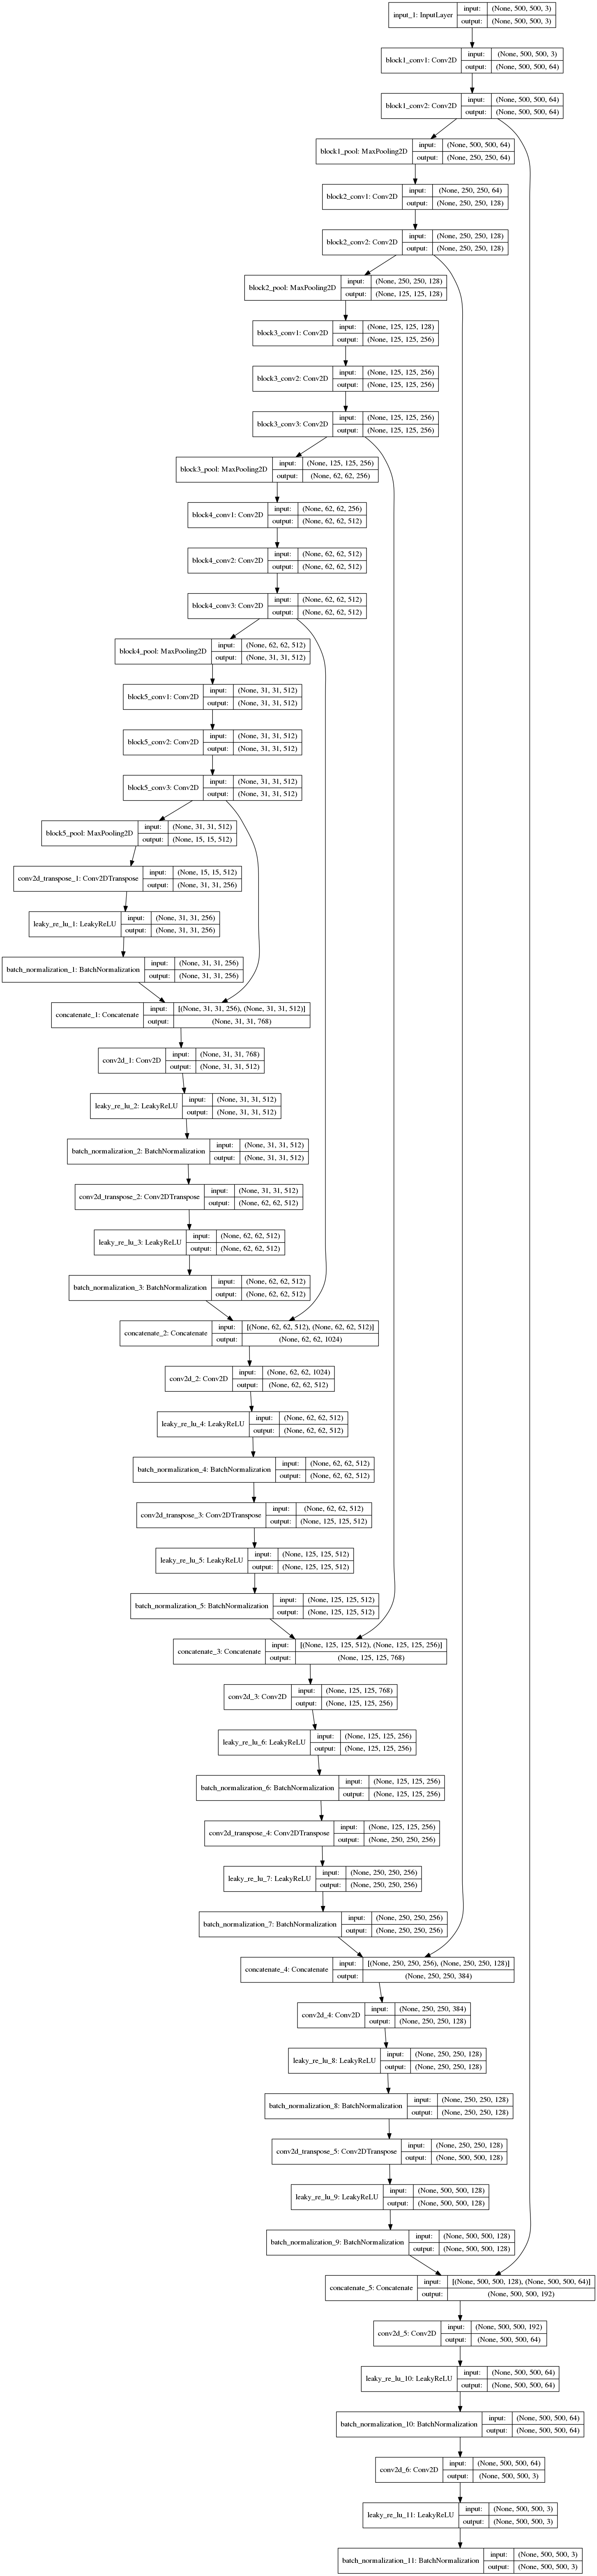

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
Model_.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint('model_TL_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_.fit_generator(GenerateInputs(X_,y_),epochs=433,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=5,shuffle=True)

Epoch 1/433
5/5 [==============================] - 11s 2s/step - loss: 168.2505 - acc: 0.6018

Epoch 00001: loss improved from inf to 168.25055, saving model to model_TL_UNET.h5
Epoch 2/433
5/5 [==============================] - 1s 200ms/step - loss: -85.6910 - acc: 0.5640

Epoch 00002: loss improved from 168.25055 to -85.69103, saving model to model_TL_UNET.h5
Epoch 3/433
5/5 [==============================] - 1s 198ms/step - loss: -284.0450 - acc: 0.2964

Epoch 00003: loss improved from -85.69103 to -284.04496, saving model to model_TL_UNET.h5
Epoch 4/433
5/5 [==============================] - 1s 199ms/step - loss: -270.3323 - acc: 0.2732

Epoch 00004: loss did not improve from -284.04496
Epoch 5/433
5/5 [==============================] - 1s 199ms/step - loss: -170.0695 - acc: 0.2914

Epoch 00005: loss did not improve from -284.04496
Epoch 6/433
5/5 [==============================] - 1s 215ms/step - loss: -354.6699 - acc: 0.2329

Epoch 00006: loss improved from -284.04496 to -354.669

In [ ]:
TransferLearningModel = load_model('model_TL_UNET.h5')

In [ ]:
img_x = cv.imread(InputPath + "render/render0001.png")
img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

In [ ]:
prediction = TransferLearningModel.predict(img_x)

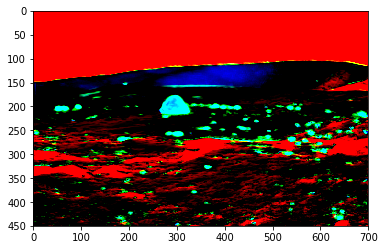

In [ ]:
pred = prediction.reshape(500,500,3)
pred_ = cv.resize(pred,(700,450))
plt.imshow(pred_)

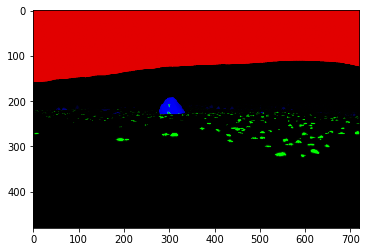

In [ ]:
img = cv.imread(InputPath+"ground/ground0001.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

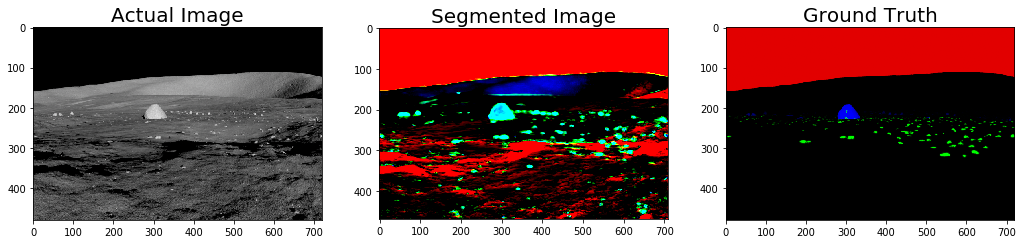

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_0 = cv.imread(InputPath+"render/render0001.png")
image_0 = cv.cvtColor(image_0, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_0)
image_0 = cv.resize(image_0,(500,500))
image_0 = image_0.reshape(1,500,500,3)
prediction_0 = TransferLearningModel.predict(image_0)
pred_0 = prediction_0.reshape(500,500,3)
pred_0 = cv.resize(pred_0,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_0)
plt.subplot(5,5,1+2)
img_g0 = cv.imread(InputPath+"ground/ground0001.png")
img_g0 = cv.cvtColor(img_g0, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g0)

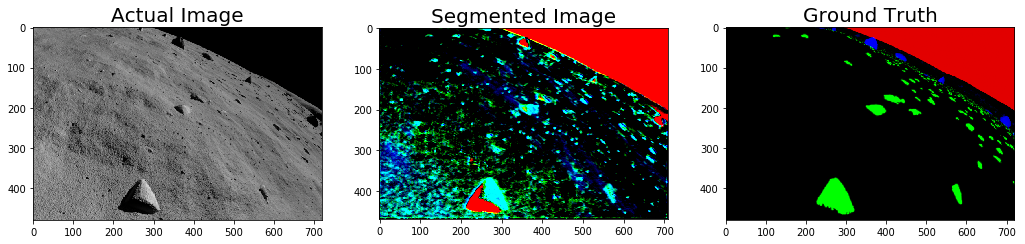

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(InputPath+"render/render2381.png")
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_1)
image_1 = cv.resize(image_1,(500,500))
image_1 = image_1.reshape(1,500,500,3)
prediction_1 = TransferLearningModel.predict(image_1)
pred_1 = prediction_1.reshape(500,500,3)
pred_1 = cv.resize(pred_1,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_1)
plt.subplot(5,5,1+2)
img_g = cv.imread(InputPath+"ground/ground2381.png")
img_g= cv.cvtColor(img_g, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g)

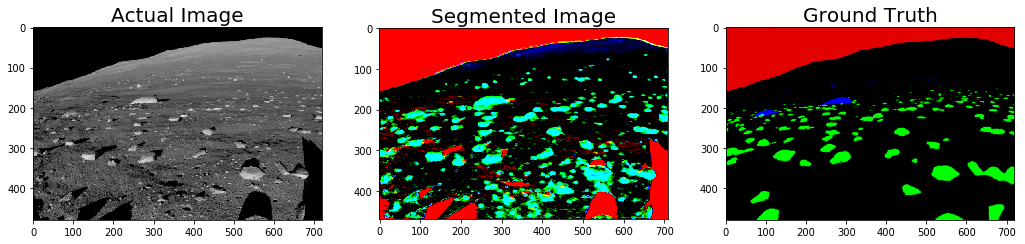

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_2 = cv.imread(InputPath+"render/render2172.png")
image_2 = cv.cvtColor(image_2, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_2)
image_2 = cv.resize(image_2,(500,500))
image_2 = image_2.reshape(1,500,500,3)
prediction_2 = TransferLearningModel.predict(image_2)
pred_2 = prediction_2.reshape(500,500,3)
pred_2 = cv.resize(pred_2,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_2)
plt.subplot(5,5,1+2)
img_g2 = cv.imread(InputPath+"ground/ground2172.png")
img_g2= cv.cvtColor(img_g2, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g2)

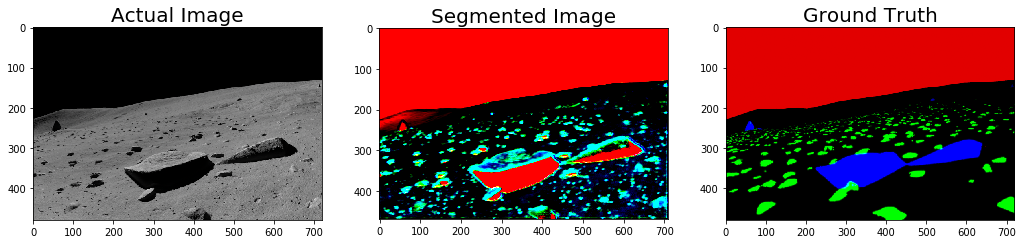

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_3 = cv.imread(InputPath+"render/render2770.png")
image_3 = cv.cvtColor(image_3, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_3)
image_3 = cv.resize(image_3,(500,500))
image_3 = image_3.reshape(1,500,500,3)
prediction_3 = TransferLearningModel.predict(image_3)
pred_3 = prediction_3.reshape(500,500,3)
pred_3 = cv.resize(pred_3,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_3)
plt.subplot(5,5,1+2)
img_g3 = cv.imread(InputPath+"ground/ground2770.png")
img_g3= cv.cvtColor(img_g3, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g3)

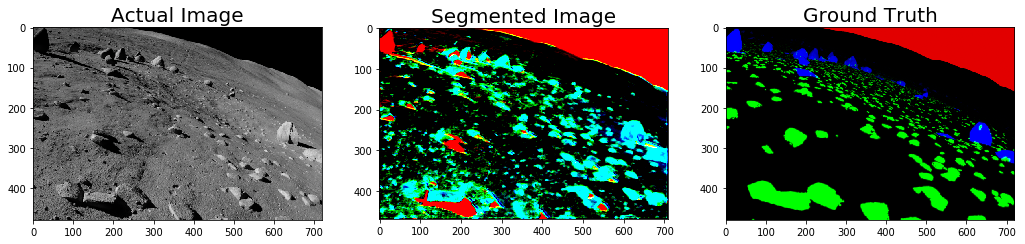

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_4 = cv.imread(InputPath+"render/render2368.png")
image_4 = cv.cvtColor(image_4, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_4)
image_4 = cv.resize(image_4,(500,500))
image_4 = image_4.reshape(1,500,500,3)
prediction_4 = TransferLearningModel.predict(image_4)
pred_4 = prediction_4.reshape(500,500,3)
pred_4 = cv.resize(pred_4,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_4)
plt.subplot(5,5,1+2)
img_g4 = cv.imread(InputPath+"ground/ground2368.png")
img_g4= cv.cvtColor(img_g4, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g4)

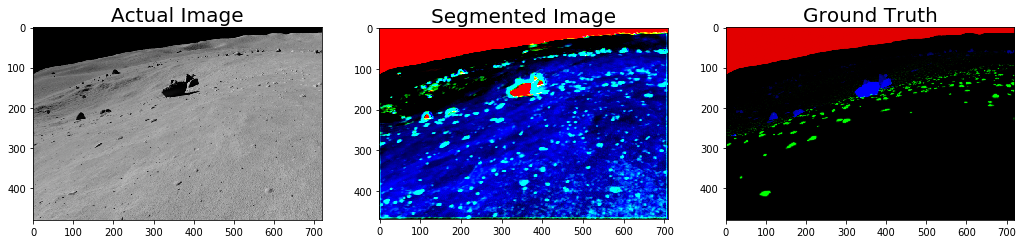

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_5 = cv.imread(InputPath+"render/render2262.png")
image_5 = cv.cvtColor(image_5, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_5)
image_5 = cv.resize(image_5,(500,500))
image_5 = image_5.reshape(1,500,500,3)
prediction_5 = TransferLearningModel.predict(image_5)
pred_5 = prediction_5.reshape(500,500,3)
pred_5 = cv.resize(pred_5,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_5)
plt.subplot(5,5,1+2)
img_g5 = cv.imread(InputPath+"ground/ground2262.png")
img_g5 = cv.cvtColor(img_g5, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g5)

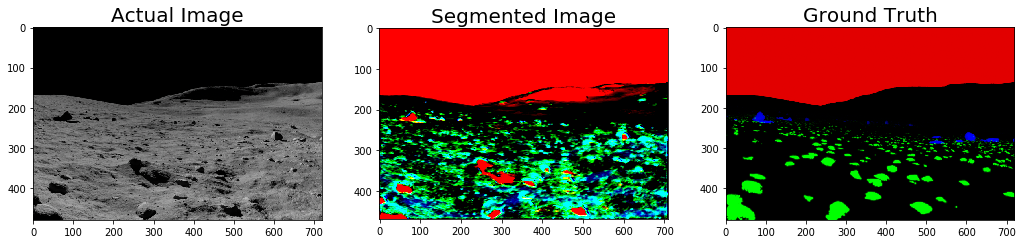

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_6 = cv.imread(InputPath+"render/render2453.png")
image_6 = cv.cvtColor(image_6, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_6)
image_6 = cv.resize(image_6,(500,500))
image_6 = image_6.reshape(1,500,500,3)
prediction_6 = TransferLearningModel.predict(image_6)
pred_6 = prediction_6.reshape(500,500,3)
pred_6 = cv.resize(pred_6,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_6)
plt.subplot(5,5,1+2)
img_g6 = cv.imread(InputPath+"ground/ground2453.png")
img_g6 = cv.cvtColor(img_g6, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g6)

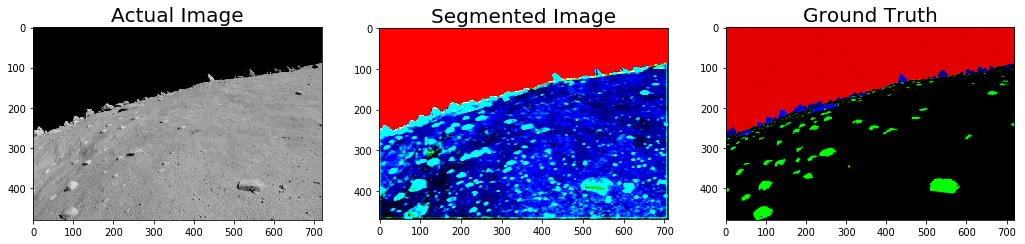

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_7 = cv.imread(InputPath+"render/render2400.png")
image_7 = cv.cvtColor(image_7, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_7)
image_7 = cv.resize(image_7,(500,500))
image_7 = image_7.reshape(1,500,500,3)
prediction_7 = TransferLearningModel.predict(image_7)
pred_7 = prediction_7.reshape(500,500,3)
pred_7 = cv.resize(pred_7,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_7)
plt.subplot(5,5,1+2)
img_g7 = cv.imread(InputPath+"ground/ground2400.png")
img_g7 = cv.cvtColor(img_g7, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g7)

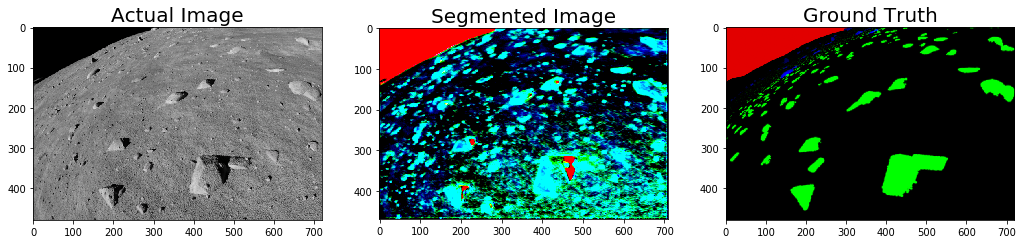

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_8 = cv.imread(InputPath+"render/render2502.png")
image_8 = cv.cvtColor(image_8, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_8)
image_8 = cv.resize(image_8,(500,500))
image_8 = image_8.reshape(1,500,500,3)
prediction_8 = TransferLearningModel.predict(image_8)
pred_8 = prediction_8.reshape(500,500,3)
pred_8 = cv.resize(pred_8,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_8)
plt.subplot(5,5,1+2)
img_g8 = cv.imread(InputPath+"ground/ground2502.png")
img_g8 = cv.cvtColor(img_g8, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g8)

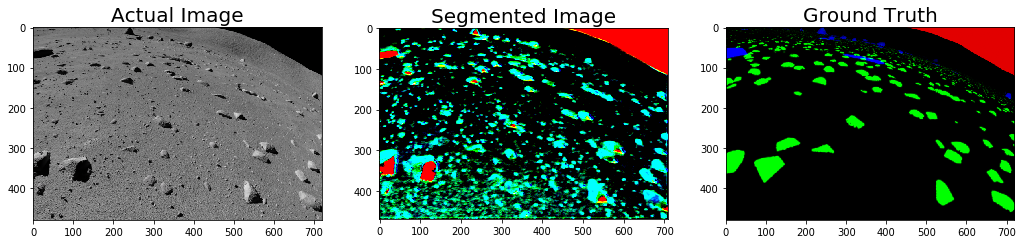

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_9 = cv.imread(InputPath+"render/render2222.png")
image_9 = cv.cvtColor(image_9, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_9)
image_9 = cv.resize(image_9,(500,500))
image_9 = image_9.reshape(1,500,500,3)
prediction_9 = TransferLearningModel.predict(image_9)
pred_9 = prediction_9.reshape(500,500,3)
pred_9 = cv.resize(pred_9,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_9)
plt.subplot(5,5,1+2)
img_g9 = cv.imread(InputPath+"ground/ground2222.png")
img_g9 = cv.cvtColor(img_g9, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g9)

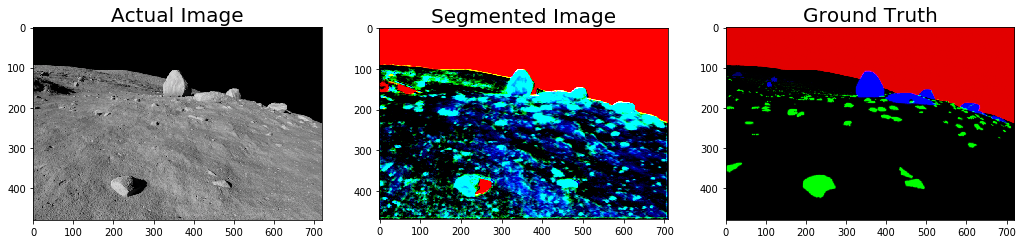

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_10 = cv.imread(InputPath+"render/render2560.png")
image_10 = cv.cvtColor(image_10, cv.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_10)
image_10 = cv.resize(image_10,(500,500))
image_10 = image_10.reshape(1,500,500,3)
prediction_10 = TransferLearningModel.predict(image_10)
pred_10 = prediction_10.reshape(500,500,3)
pred_10 = cv.resize(pred_10,(710,470))
plt.subplot(5,5,1+1)
plt.title("Segmented Image",fontsize=20)
plt.imshow(pred_10)
plt.subplot(5,5,1+2)
img_g10 = cv.imread(InputPath+"ground/ground2560.png")
img_g10 = cv.cvtColor(img_g10, cv.COLOR_BGR2RGB)
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_g10)